In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
def get_stock_data(ticker, start='2020-01-01'):
    data = yf.download(ticker, start=start)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

In [3]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [4]:
def train_lstm_model(X_train, y_train, model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    model.save(f"{model_name}.h5")
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test = X[-forecast_days:]

    try:
        model = load_model(f"{ticker}_model.h5")
    except:
        model = train_lstm_model(X_train, y_train, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y[-forecast_days:].shape[0], len(feature_columns)))
    y_actual[:, 0] = y[-forecast_days:]  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)

    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    plt.plot(last_dates, predictions, label='LSTM Forecast')
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_multiple_indices(tickers, forecast_days=30, epoch=50):
    plt.figure(figsize=(12, 6))

    for ticker in tickers:
        df = get_stock_data(ticker)

        # Check if data is empty
        if df.empty:
            print(f"⚠️ Warning: No data found for {ticker}. Skipping...")
            continue

        time_step = 60
        feature_columns = ['Close', 'RSI', 'MA_10', 'MA_30', 'MA_50', 'MA_200', 'Upper_Band', 'Lower_Band']

        # Preprocess Data
        try:
            X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
        except ValueError as e:
            print(f"⚠️ Error processing {ticker}: {e}")
            continue  # Skip this index

        if len(X) == 0 or len(y) == 0:
            print(f"⚠️ Warning: Insufficient data for {ticker}. Skipping...")
            continue

        X_train, y_train = X[:-forecast_days], y[:-forecast_days]
        X_test, y_test = X[-forecast_days:], y[-forecast_days:]

        try:
            model = load_model(f"{ticker}_model.h5")
        except:
            model = train_lstm_model(X_train, y_train, ticker, epoch)

        # Make Predictions
        predictions = model.predict(X_test)
        dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))
        dummy_array[:, 0] = predictions[:, 0]
        predictions = scaler.inverse_transform(dummy_array)[:, 0]

        # Inverse transform actual y values
        y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
        y_actual[:, 0] = y_test
        y_actual = scaler.inverse_transform(y_actual)[:, 0]

        # Compute Metrics
        rmse = np.sqrt(mean_squared_error(y_actual, predictions))
        mae = mean_absolute_error(y_actual, predictions)
        mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100
        r2 = r2_score(y_actual, predictions)

        print(f"📊 Performance Metrics for {ticker}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}\n")

        # Sentiment Adjustment
        headline = f"{ticker} stock market update"
        sentiment_score = get_sentiment_score(headline)
        sentiment_adjustment = 1 + (sentiment_score * 0.03)
        adjusted_preds = predictions * sentiment_adjustment

        # Plot Results for each Index
        last_dates = df.index[-forecast_days:]
        plt.plot(last_dates, adjusted_preds, label=f"{ticker} Forecast")
        plt.plot(last_dates, y_actual, linestyle="dashed", label=f"{ticker} Actual")

    plt.title(f"Stock Market Forecast vs Actual Data ({forecast_days} days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.1199 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0201 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0129 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0087 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0081 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0079 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
RMSE: 124.4535047737301
MAE: 101.27632150711725
MAPE: 2.767420684321868
R^2 Score: 0.12366038310889571


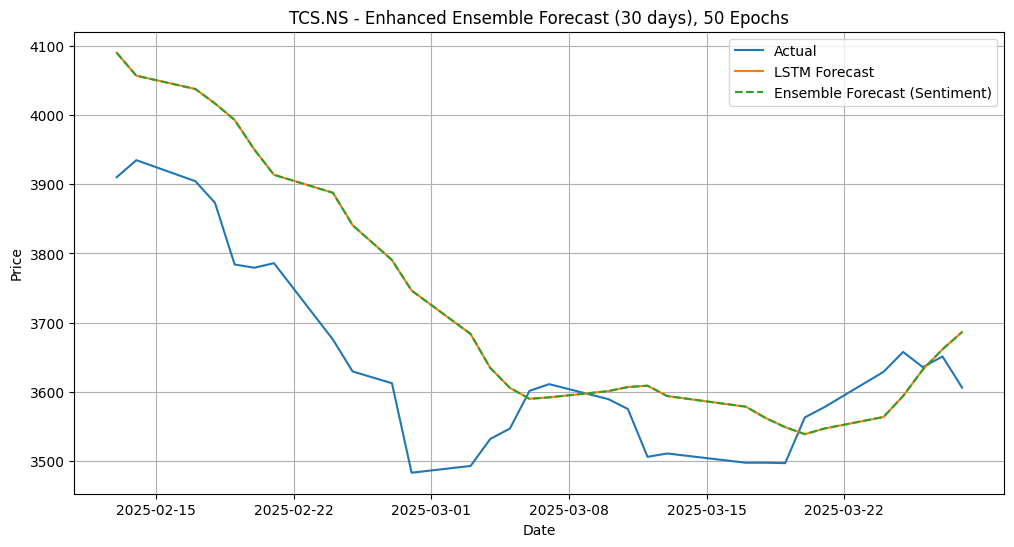

[*********************100%***********************]  1 of 1 completed

Epoch 1/100



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0672 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0126 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0101 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0081 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0080 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
RMSE: 97.29090184876307
MAE: 81.13037126652489
MAPE: 2.2261063066747027
R^2 Score: 0.46444677257884703


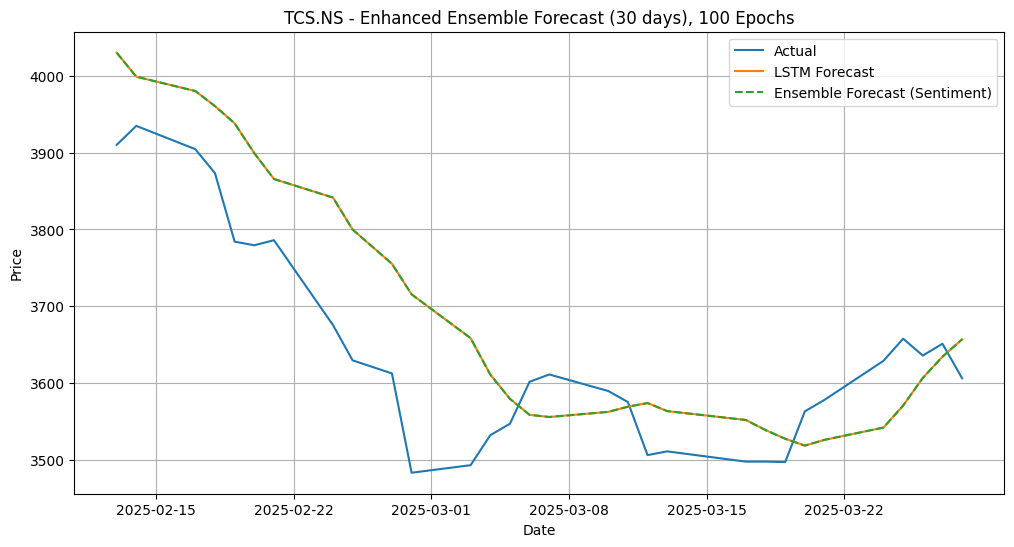

[*********************100%***********************]  1 of 1 completed

Epoch 1/150



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0840 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0120 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0079 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0060 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
RMSE: 88.04758960058145
MAE: 73.568112778879
MAPE: 2.0236384565879515
R^2 Score: 0.5613752588704726


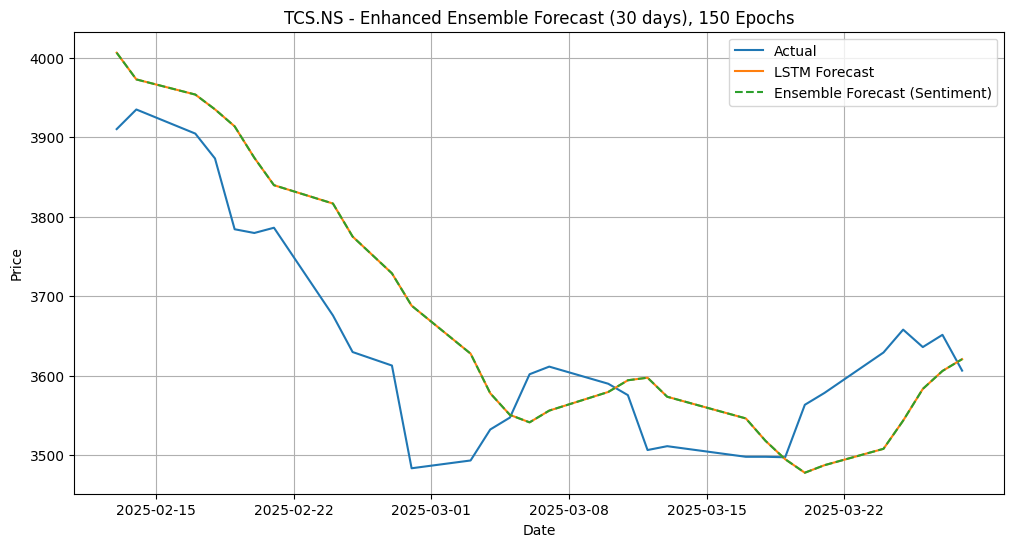

[*********************100%***********************]  1 of 1 completed

Epoch 1/200



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0718 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0122 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0088 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0076 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0062 - learning_rate: 0.0010
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
RMSE: 119.16717443777223
MAE: 103.09358375968489
MAPE: 2.8453496186300105
R^2 Score: 0.19652666848797817


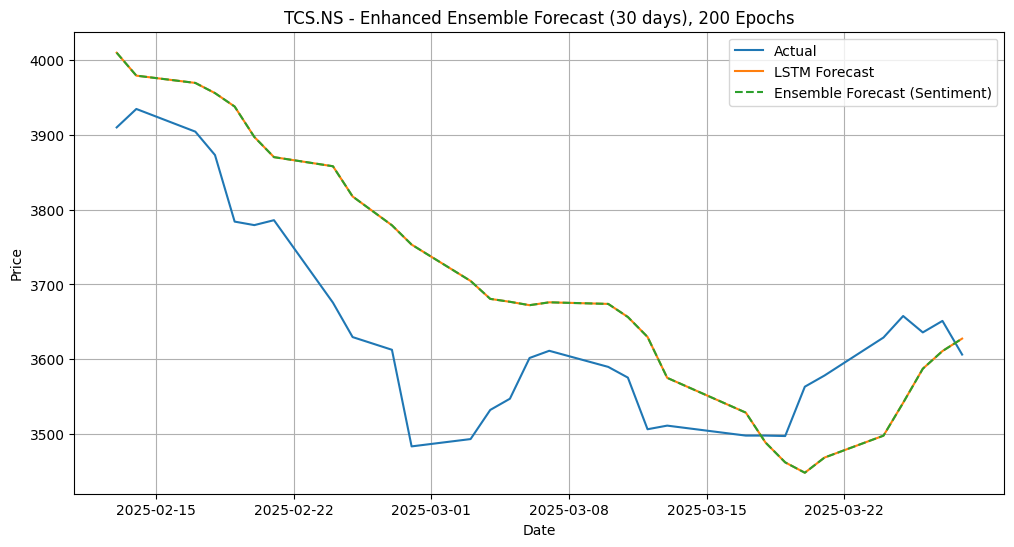

[*********************100%***********************]  1 of 1 completed

Epoch 1/250



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0779 - learning_rate: 0.0010
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0146 - learning_rate: 0.0010
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0062 - learning_rate: 0.0010
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0068 - learning_rate: 0.0010
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 9/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 10/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 11/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
RMSE: 94.76357954610958
MAE: 80.29665488844815
MAPE: 2.200117285411174
R^2 Score: 0.4919094741673189


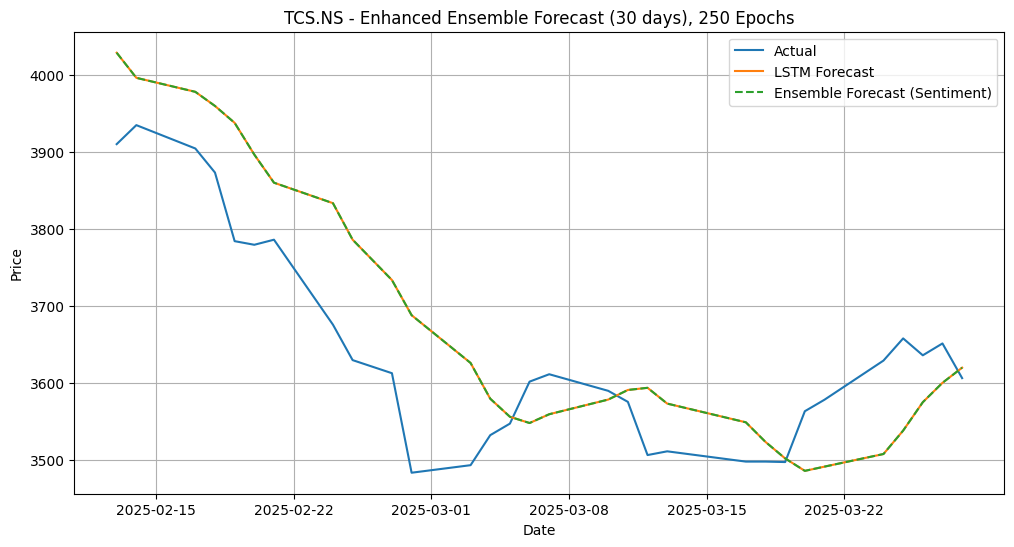

In [7]:
forecast_ensemble("TCS.NS",epoch=50)
forecast_ensemble("TCS.NS",epoch=100)
forecast_ensemble("TCS.NS",epoch=150)
forecast_ensemble("TCS.NS",epoch=200)
forecast_ensemble("TCS.NS",epoch=250)

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.1063 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0139 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0076 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0087 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0070 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0048 - learning_rate: 0.0010
Epoch 12/50
32/32 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
RMSE: 31.307698012856708
MAE: 24.929546089317956
MAPE: 2.001019368637601
R^2 Score: 0.13478585449698


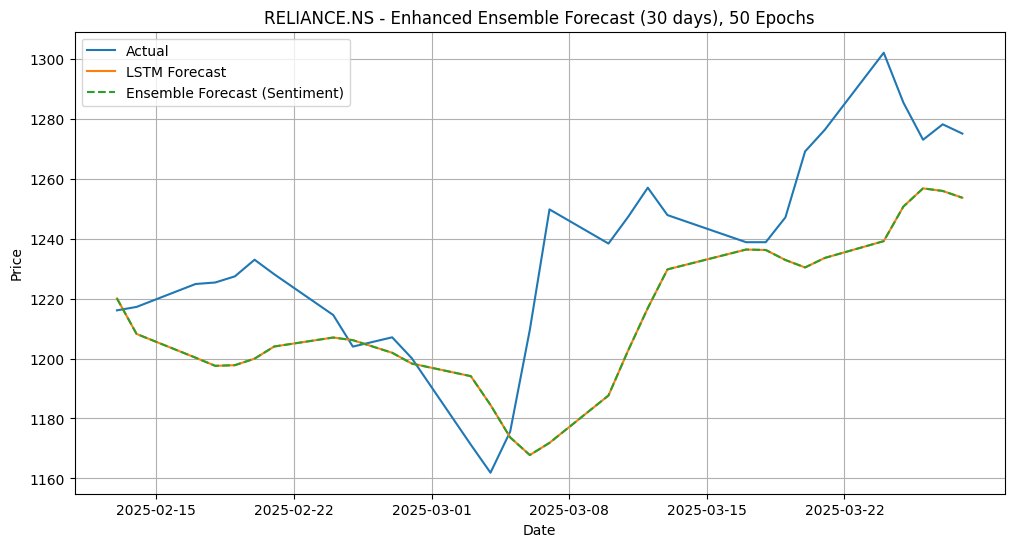

[*********************100%***********************]  1 of 1 completed

Epoch 1/100



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0719 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0196 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0084 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0100 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0060 - learning_rate: 0.0010
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0091 - learning_rate: 0.0010
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0055 - learning_rate: 0.0010
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
RMSE: 23.81998926073715
MAE: 19.478509604333947
MAPE: 1.5805435506361463
R^2 Score: 0.499153709269861


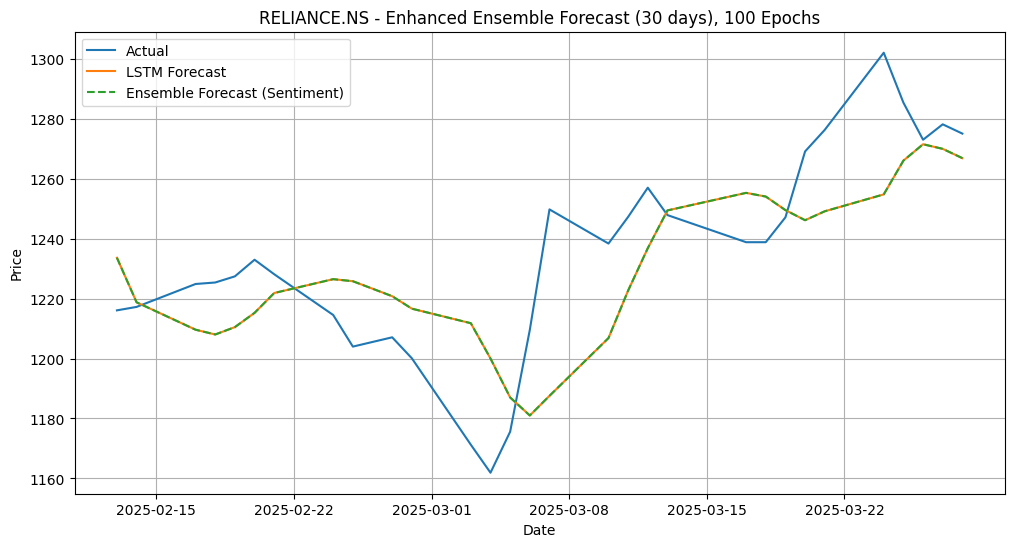

[*********************100%***********************]  1 of 1 completed

Epoch 1/150



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.1371 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0192 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0128 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0109 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0095 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0074 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0068 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0078 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0060 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
RMSE: 23.57304370862173
MAE: 18.18543441145824
MAPE: 1.4771132549362476
R^2 Score: 0.5094845829199843


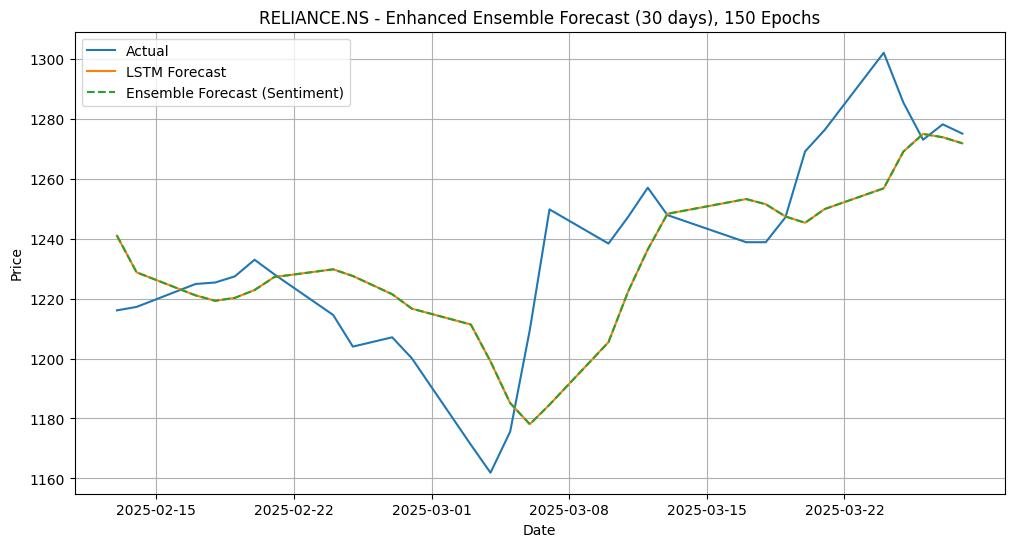

[*********************100%***********************]  1 of 1 completed

Epoch 1/200



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0808 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0165 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0159 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0112 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0091 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
RMSE: 30.259322205543903
MAE: 26.015640933523233
MAPE: 2.1248075428044135
R^2 Score: 0.1917611339762051


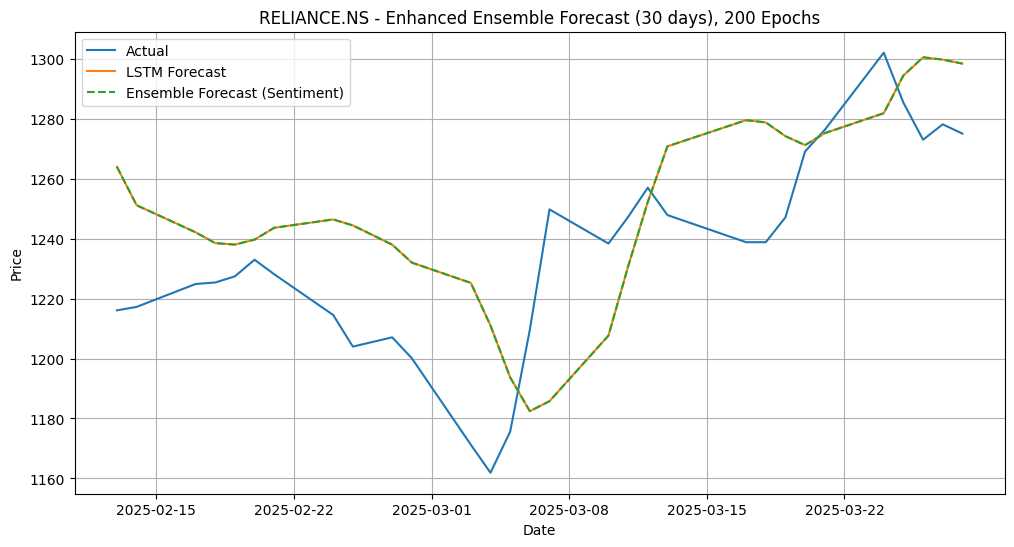

[*********************100%***********************]  1 of 1 completed

Epoch 1/250



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.1120 - learning_rate: 0.0010
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0141 - learning_rate: 0.0010
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0107 - learning_rate: 0.0010
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 9/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 10/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0062 - learning_rate: 0.0010
Epoch 11/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 12/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
RMSE: 23.800472225433982
MAE: 18.022436088711764
MAPE: 1.456813675161359
R^2 Score: 0.49997411519173196


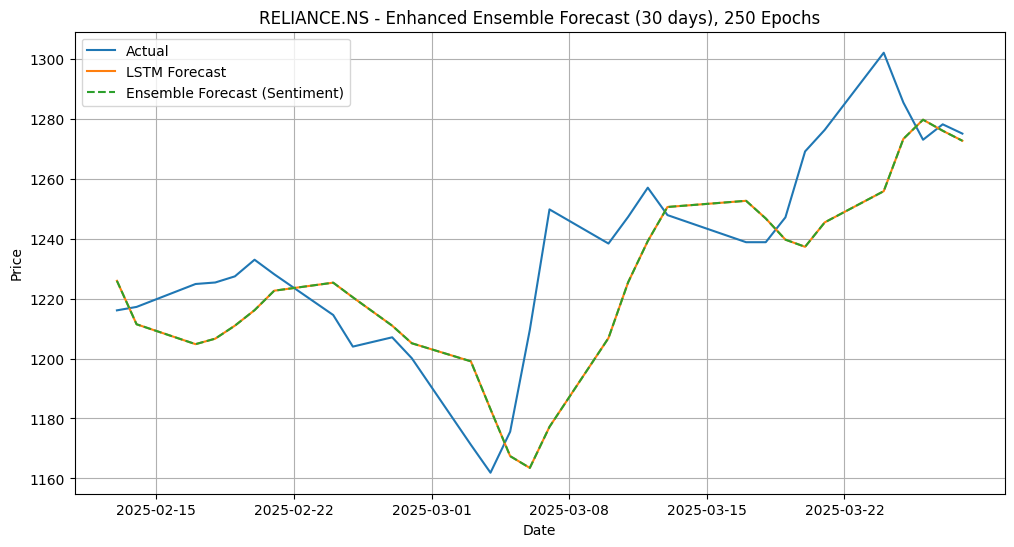

In [8]:

forecast_ensemble("RELIANCE.NS",epoch=50)
forecast_ensemble("RELIANCE.NS",epoch=100)
forecast_ensemble("RELIANCE.NS",epoch=150)
forecast_ensemble("RELIANCE.NS",epoch=200)
forecast_ensemble("RELIANCE.NS",epoch=250)

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.1451 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0155 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 12/50
32/32 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 772.60
MAE: 703.83
MAPE: 3.11%
R² Score: -1.8685



[*********************100%***********************]  1 of 1 completed

Epoch 1/50



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0952 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0164 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0125 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0093 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 12/50
32/32 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 369.94
MAE: 315.75
MAPE: 1.36%
R² Score: 0.4403



[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNX500. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


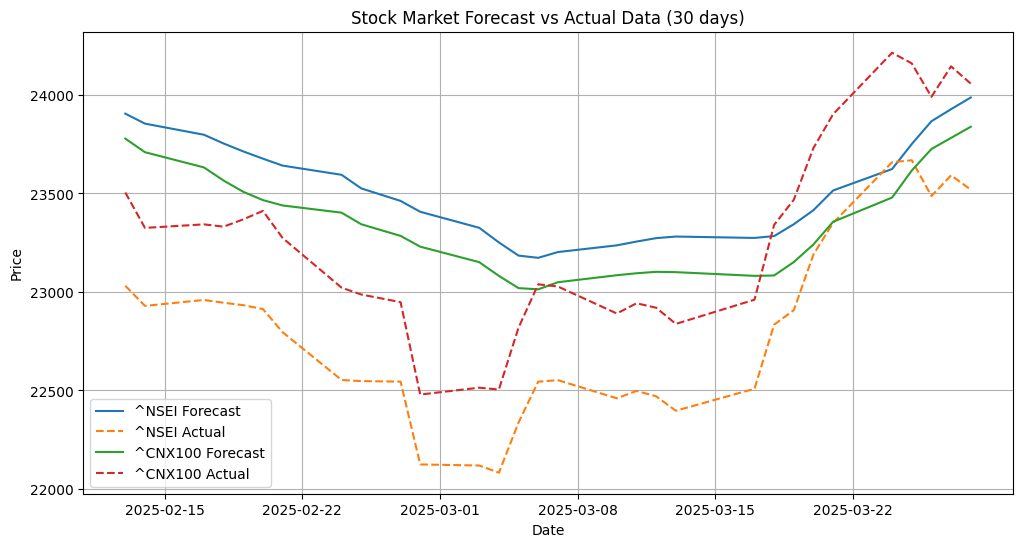

In [9]:
nifty_indices = ['^NSEI', '^CNX100', '^CNX500', '^CNXMIDCAP']
forecast_multiple_indices(nifty_indices)
